In [297]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
from iminuit import Minuit, cost
from argparse import Namespace
import pandas as pd
import os
import matplotlib.pyplot as plt
import h5py as h5
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from IPython.display import display, Math

In [298]:
KB = c.Boltzmann
hbar = c.Planck

In [365]:
def QT(T,d0, q0, alpha, omega):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0

def kondo(T,d0, q0, alpha, omega, b, T_k):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0 - b*np.log(T/T_k)

def retta(x, m, q):
    return m*x + q

def resonance(x, x0, Q, Q_c, phi0):
    num = np.exp(1j*phi0)
    den = 1 + 2*1j*Q*(x-x0)/x0
    return abs(1 - (Q/Q_c)*(num/den))

def model(x,m,q,x0,Q,Q_c,phi0):
    return retta(x,m,q) * resonance(x,x0,Q,Q_c,phi0)



def FWHM(x,y):
    x = np.array(x)
    y = np.array(y)
    half = np.max(y) - (np.max(y)-np.abs(y)) / 2.
    minimums = x[np.where(y < half)]
    return (max(minimums) - min(minimums))

def mod(x,y):
    return np.sqrt(x**2 + y**2)
    
def Q_stima(x0,w):
    if (((x0 is None) or (w is None)) or w==0):
        print('Q_stima: None detected!')
        return 0
    else:
        return x0/(2*w)
    
def Sort_Tuple(tup):
 
    # getting length of list of tuples
    lst = len(tup)
    for i in range(0, lst):
        for j in range(0, lst-i-1):
            if (tup[j][1] > tup[j + 1][1]):
                temp = tup[j]
                tup[j] = tup[j + 1]
                tup[j + 1] = temp
    return tup


def plot_res(m2, dfs2, t, func, fill):

    for m in range(len(dfs2)):

        chi2 = m2[m].fval
        ndof = m2[m].ndof
        
        title = [
            f"chi2/ndof = {chi2:.1f}/{ndof}={chi2/ndof:.1f}",
        ]

    for par in m2[m].parameters:
        title.append(
            f"{par} = {m2[m].values[par]:.4f} +/- {m2[m].errors[par]:.4f}"
        )
    
    for n in range(4):
    
        plt.scatter(np.array(dfs2[m][n]['f'])*1e-9, np.array(dfs2[m][n]['S21']), marker='.', s=1, label='Raw Data', color='black')
        plt.plot(np.array(dfs2[m][n]['f'])*1e-9, func(np.array(dfs2[m][n]['f']), *m2[m].values[:]), label='Model', color='red')
        if (fill==True):
            plt.fill_between(np.array(dfs2[m][n]['f'])*1e-9, np.array(dfs2[m][n]['S21'])*(1-(1e-3)), np.array(dfs2[m][n]['S21'])*(1+1e-3), alpha=0.5, color='blue')
        plt.xlabel(r'$\nu$ [GHz]')
        plt.ylabel(r'$|S_{21}|$')
        plt.legend(title="\n".join(title), fontsize='large')
        plt.title('T: '+str(t[m])+' Res: '+str(n))
        plt.grid()
        plt.show()
    return


def plot_res_matrix(m, dfs, t, func, rows, columns, fill):

    fig, ax = plt.subplots(rows, columns, figsize=(60,20))

    for row in range(rows):
        for col in range(columns):
            i = row*columns + col
            chi2 = m[i].fval
            ndof = m[i].ndof

            title = [
                f"chi2/ndof = {chi2:.1f}/{ndof}={chi2/ndof:.1f}",
            ]

            for par in m[i].parameters:
                title.append(
                    f"{par} = {m[i].values[par]:.4f} +/- {m[i].errors[par]:.4f}"
                )
            
            ax[row][col].scatter(np.array(dfs[row][col]['f'])*1e-9, np.array(dfs[row][col]['S21']), marker='.', s=1, label='Raw Data', color='black')
            ax[row][col].plot(np.array(dfs[row][col]['f'])*1e-9, func(np.array(dfs[row][col]['f']), *m[i].values[:]), label='Model', color='red')
            if (fill==True):
                ax[row][col].fill_between(np.array(dfs[row][col]['f'])*1e-9, np.array(dfs[row][col]['S21'])*(1-(1e-3)), np.array(dfs[row][col]['S21'])*(1+1e-3), alpha=0.5, color='blue')
            ax[row][col].set_facecolor('bisque')
            ax[row][col].set_xlabel(r'$\nu$ [GHz]')
            ax[row][col].set_ylabel(r'$|S_{21}|$')
            ax[row][col].legend(title="\n".join(title), fontsize='large')
            ax[row][col].set_title('T: '+str(t[i]))
            ax[row][col].grid()
            fig.tight_layout()

    return fig

def read_files(dir = 'F:\\LabIV\\QTLab2324\\IRdetection\\Instruments\\Test_data\\data_19_02_set2\\'):

    dfs, dictionaries = [], []

    for folder in os.listdir(dir):
        if ('T' in folder):
            parent = dir+folder+'\\'
            dictionaries = []
            for (i,filename) in enumerate(os.listdir(parent)):
                my_dest = filename.replace('.h5','.hdf5')
                my_source = parent + filename
                my_dest = parent + my_dest
                os.rename(my_source, my_dest)
                with h5.File(my_dest, 'r') as r:
                    group = r.require_group(name='raw_data')
                    dic = dict()
                    for c in group.items():
                        dic[c[0]] = c[1][:]
                dictionaries.append(dic)
        dfs.append(dictionaries)
    return dfs


def resonance2(f, a, b, Q, f0):
    x = (f-f0)/f0
    return a + b/np.sqrt(1 + (2*Q*x)**2)

In [366]:
temps = np.arange(50, 290, 20)

In [367]:
dfs = read_files()
for i in range(len(dfs)):
    for j in range(4):
        dfs[i][j]['S21'] = 20*np.log10(np.sqrt(np.array(dfs[i][j]['i'])**2 + np.array(dfs[i][j]['q'])**2))

In [381]:
min_freq = dfs[3][0]['f'][np.argmin(dfs[3][0]['S21'])]

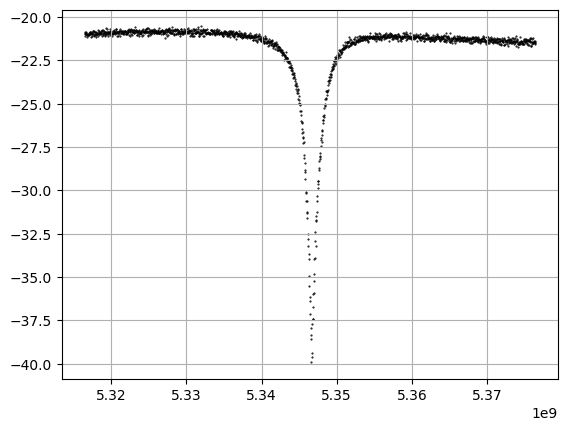

In [383]:
plt.scatter(dfs[3][0]['f'],dfs[3][0]['S21'], marker='.', s=1, color='black')
plt.grid()

We have to estimate $\sigma$\
To do this we will grab the first 100 data points and get the _RMS_

In [385]:
condition = lambda x: (x<5.34*1e9)
fs = [x for x in dfs[3][0]['f'] if condition(x)]
filtered_indices = [i for i, x in enumerate(dfs[3][0]['f']) if condition(x)]
S21s = [dfs[3][0]['S21'][i] for i in filtered_indices]


pol_amp = np.polyfit(fs, S21s, 2)
rms = np.sqrt(np.mean((np.polyval(pol_amp, fs)-S21s)**2))
print('RMS: ', rms)

RMS:  0.10541119283896574


_Let's normalize data and center them around the resonance minimum_\
_**Remember: x axis will be in GHz!**_

In [392]:
condition = lambda x: (x>min_freq*(1-0.002) and x<min_freq*(1+0.002))
f = [x for x in dfs[3][0]['f'] if condition(x)]
f = (f - min_freq)/1e9
filtered_indices = [i for i, x in enumerate(dfs[3][0]['f']) if condition(x)]
S21 = [dfs[3][0]['S21'][i] for i in filtered_indices]
S21 = S21 / S21[np.argmin(S21)]

_Plotting..._

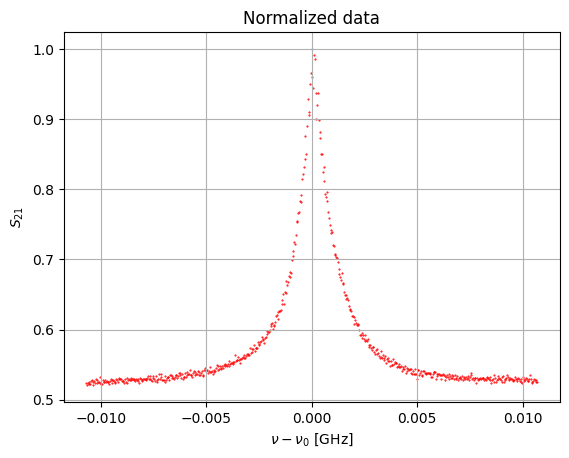

In [393]:
plt.scatter(f,S21,marker='.',s=1, color='red')
plt.xlabel(r'$\nu-\nu_{0}$ [GHz]')
plt.ylabel('$S_{21}$')
plt.title('Normalized data')
plt.grid()

Now we have to estimate resonance parameters: $A$, $B$, $Q$,$\nu_{0}$

In [394]:
f0_init = f[np.argmin(S21)]
Q_init = Q_stima(f0_init,FWHM(f,S21))
A_init = 0.3
B_init = max(S21)-A_init
p0 = [A_init,B_init, Q_init, f0_init]
p0_names = ['A','B','Q',r'$\nu_{0}$']
#bounds = [(None, None, None, min_freq*(1-0.1)), (None, None, None,min_freq*(1+0.1))]
print(Q_init)

-0.24912280701753062


In [395]:
popt, pcov = curve_fit(resonance2, f, S21, p0, maxfev=10000)

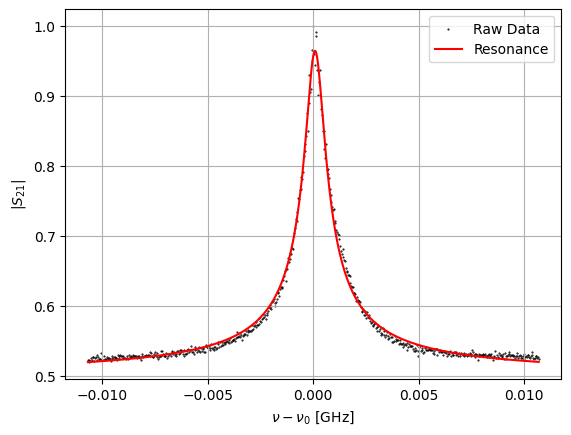

In [396]:
plt.scatter(f, S21, marker='.', s=1, label='Raw Data', color='black')
plt.plot(f, resonance2(f, *popt), label='Resonance', color='red')
#plt.fill_between(f, f-rms, f+rms, alpha=0.5, color='blue')
plt.xlabel(r'$\nu- \nu_{0}$ [GHz]')
plt.ylabel(r'$|S_{21}|$')
plt.legend()
plt.grid()

In [397]:
count = 0
pm = r'$\pm$'
for (name,value) in zip(p0_names,popt):
    count += 1
    display(Math(name+' = '+str(value)))
    display(Math(name+' err = '+str(np.diag(pcov)[count-1]) ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>